# Création d'un scatter plot interactif

#### Visualisation des abondances et Pathway pour chaque protéine

Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**). 


In [60]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDBscratch"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

sys.path.append(libDir)

In [61]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG
# We use notebook backend to have interactivity support
%matplotlib notebook 

import matplotlib.pyplot as plt

#### Exemple pour commencer
Observer la cellule suivante qui illustre la construction d'un scatter plot et des améliorations possibles.

###### Creation du scatter plot
[matplotlib.axes.Axes.scatter()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.scatter.html) permet d'intialiser le graphique.
###### Modification continue du scatter plot
Mais cette fonction retourne aussi un objet [PathCollection](https://matplotlib.org/3.1.1/api/collections_api.html) qui permet de modifier à posteriori le rendu des points du scatter plot.
###### Interactivité
L'affichage d'une figure via la méthode `fig.canvas.mpl_connect('EVENT_NAME', callbackFunction)` permet d'associer à [un évenement sur la figure](https://matplotlib.org/3.1.1/users/event_handling.html) l'execution du fonction (*callbackFunction*)

###### Illustration ci-dessous

<IPython.core.display.Javascript object>


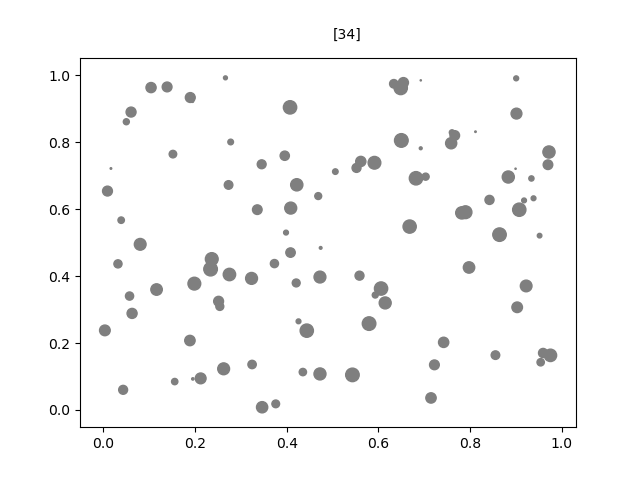

In [7]:
x, y, c, s = np.random.rand(4, 100)

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    col.set_sizes( np.random.rand(100) * 100 )
    
def onpick(event):
    ind = event.ind
    tx = str(ind)
    text.set_text(tx)
    col.set_sizes( np.random.rand(100) * 100 )
    col.set_color( np.full(100, 'tab:gray') )
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, 100*s, c, picker=True)
text = ax1.text(0.5,1.1, "", va="bottom", ha="left")

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onpick)

## Volcano Plot simple
Ce type de figure représente pour chaque protéine en abscisse le taux d'abondance et en ordonnées la précision de la mesure.
Réaliser les graphiques suivants.
![caption](../figs/volcano_simple.png)

#### Lecture des données
* Liste des ratios d'abondance 
* Liste des pValue experimentales

In [62]:
import pandas
df=pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")

dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)
dfClean.loc[:,'LOG10 Adj.P-val'] = dfClean.loc[:,'LOG10 Adj.P-val'].astype(float)


saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
abundance = dfClean[ : ]['Log2 Corrected Abundance Ratio'].tolist()
allList = dfClean[ : ]['Accession'].tolist()
pvalue = dfClean[ : ]['LOG10 Adj.P-val'].tolist()

<IPython.core.display.Javascript object>


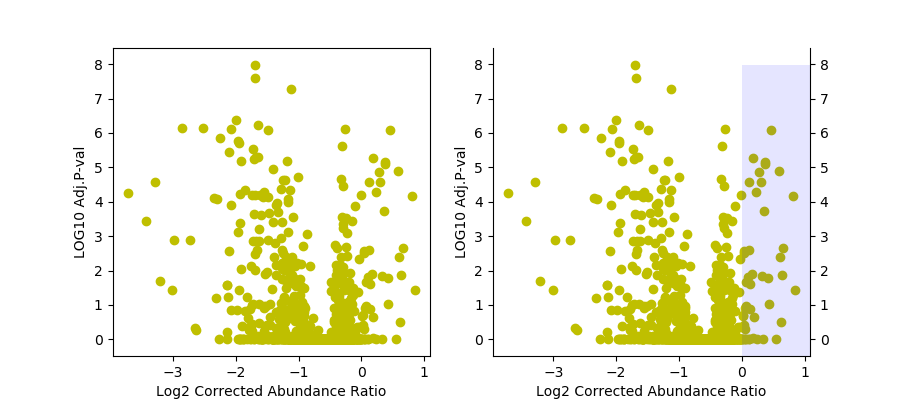

In [63]:
from matplotlib.patches import Rectangle
x = [ float(i) for i in dfClean['Log2 Corrected Abundance Ratio'].tolist() ]
y = [ float(i) for i in dfClean['LOG10 Adj.P-val'].tolist() ]
labels = dfClean['Accession'].tolist()


def drawScatter(x, y, ax=None, fig=None):
    ax.set_yticks(np.arange(min(y), max(y)+1, 1.0))
    scat = ax.scatter(x, y, color='y', picker=5)
    ax.set_ylabel('LOG10 Adj.P-val')
    ax.set_xlabel('Log2 Corrected Abundance Ratio')
    return scat, fig, ax
  

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(9,4)
drawScatter(x,y, axes[0])
drawScatter(x,y, axes[1])

axes[1].spines['top'].set_visible(False)
axes[1].tick_params(labelright=True, right=True)

x_min, x_max = axes[1].get_xlim()
y_min, y_max = axes[1].get_ylim()
tau = 0.0
p = Rectangle([tau, y_min], x_max, y_max, facecolor='blue', alpha=0.1)
r=axes[1].add_patch(p)

### 3a Volcano plot interactif

##### Lecture des données

* Liste des noms des protéines
* Liste des ratios d'abondance 
* Liste des pValue experimentales

##### Dessiner un volcano plot qui affichera le nom de la protéine clickée

<IPython.core.display.Javascript object>


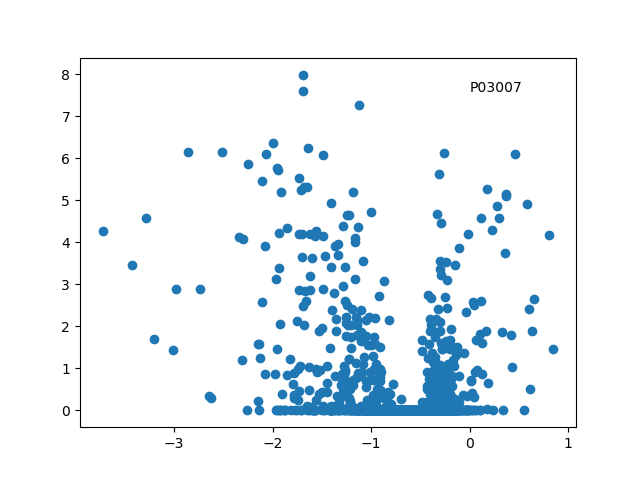

In [8]:
x,y, labels = (abundance, pvalue, allList)
def onpick(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    #print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, picker=True)

text = ax1.text(0, 7.5, "", va="bottom", ha="left")

cid = fig.canvas.mpl_connect('pick_event', onpick)

### 3b Intégration des annotations GO
#### Lectures des données
 
* Lecture des listes de protéines
    * Totale
    * Protéines surexprimées
    
* Chargement des données de *OverRepresentationAnalysis* sur le namespace GO de votre choix
    * Rappel sur le format du fichier JSON


```json
    { 
        "plasma membrane" : {
            "name" : "plasma membrane",
            "pvalue" : 0.9999980015962491,
            "proteineTotal" : [uniprotID, ..],
            "proteineSA" : [uniprotID, ..]
    
           },
       ....
     }
```

Un document JSON valide est obligatoirement un dictionnaire. Pensez, après lecture du fichier, à trier les pathways par **pvalue croissante**.

In [65]:
import json

data = {}
with open ("TP_ORA.json", 'r') as fp:
    data = json.load(fp)

pathways = sorted([ d for k,d in data.items() ], key=lambda x:x['pvalue'])
pathways

[{'name': 'ion transmembrane transport',
  'pvalue': 0.026319852884717568,
  'proteineTotal': ['P30860',
   'P37902',
   'P0AFA7',
   'P0ABJ1',
   'P0AG80',
   'P0AFC7',
   'P0A9K7',
   'Q59385',
   'P02930',
   'P23173',
   'P0A830',
   'P0AER8',
   'P33607',
   'P0ABA0',
   'P13738',
   'P0ABB4',
   'P37774',
   'P0ABA4',
   'P07001',
   'P64423',
   'P69874',
   'P06129',
   'P0C0S1',
   'P23886',
   'P0ABI8',
   'P02931',
   'P0ABI4',
   'P0AAH0',
   'P29018',
   'P0AAG3',
   'P0ABA6',
   'P0AB98',
   'P45577',
   'P0AG82',
   'P0ABB0',
   'P0A910',
   'P69829',
   'P77304',
   'P0AAF6',
   'P0A742',
   'P07109',
   'P0A6E6',
   'P08194',
   'P0C0L7'],
  'proteineSA': ['P0AER8', 'P0A910', 'P02931', 'P02930', 'P06129']},
 {'name': 'L-glutamate transmembrane transport',
  'pvalue': 0.04106508166120274,
  'proteineTotal': ['P0AER8', 'P37902'],
  'proteineSA': ['P0AER8']},
 {'name': 'drug transmembrane transport',
  'pvalue': 0.12358508050517482,
  'proteineTotal': ['P30860',
   'P0AER

### Fontionalités à implémenter au choix

* Colorier les protéines des n Pathways les plus représentés dans le namespace GO de votre choix (biological_process, molecular function, cellular component): **utiliser des palettes de couleurs catégorielles**. Priorités sera donné au pathway avec le meilleur score ORA.
* Dessiner un volcano plot qui coloriera d'une même couleur les protéines appartenant au pathway GO de la protéine clickée
* Dessiner un volcano plot qui fera disparaitre les protéines n'appartenant au même pathway GO de la protéine clickée

#### Palettes de couleurs
matplotlib propose une variété de [palettes de couleurs](https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).
##### Divergentes ou Séquentielles
![caption](../figs/cmap1.png)
![caption](../figs/cmap2.png)
##### Continues ou Catégorielles
![caption](../figs/cmap4.png)
##### Cyclique
![caption](../figs/cmap3.png)
##### Quel type de palette choisir pour colorier en fonction:
* Des pathways ?
* Des pvalues ? 

##### API colormap
###### Charger une palette de couleurs
```python
cmap = plt.get_cmap('Paired')
```
###### Connaitre son nombre d'éléments
```python
print(cmap.N)
```
###### Accéder à sa liste de couleurs
```python
print(cmap.colors)
```

In [88]:
pathways[-1]

{'name': 'anion transmembrane transport',
 'pvalue': 0.571013396124047,
 'proteineTotal': ['P30860',
  'P0A830',
  'P37902',
  'P0AER8',
  'P23886',
  'P0AG80',
  'P37774',
  'P0AAF6',
  'P0A9K7',
  'P0AAH0',
  'P08194',
  'P29018',
  'P0AAG3',
  'P07109',
  'P45577',
  'P0AG82',
  'P23173',
  'P0C0L7'],
 'proteineSA': ['P0AER8']}

12
((0.6509803921568628, 0.807843137254902, 0.8901960784313725), (0.12156862745098039, 0.47058823529411764, 0.7058823529411765), (0.6980392156862745, 0.8745098039215686, 0.5411764705882353), (0.2, 0.6274509803921569, 0.17254901960784313), (0.984313725490196, 0.6039215686274509, 0.6), (0.8901960784313725, 0.10196078431372549, 0.10980392156862745), (0.9921568627450981, 0.7490196078431373, 0.43529411764705883), (1.0, 0.4980392156862745, 0.0), (0.792156862745098, 0.6980392156862745, 0.8392156862745098), (0.41568627450980394, 0.23921568627450981, 0.6039215686274509), (1.0, 1.0, 0.6), (0.6941176470588235, 0.34901960784313724, 0.1568627450980392))


<IPython.core.display.Javascript object>


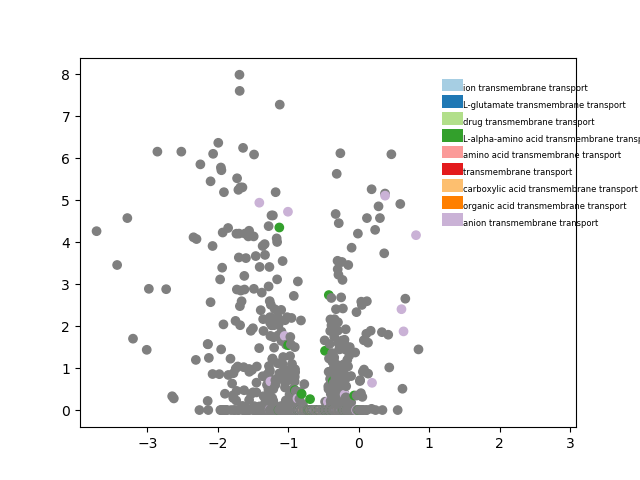

(1.1814656842564515, 7.593669599728571) 0.3 0.3
(1.1814656842564515, 7.193669599728571) 0.3 0.3
(1.1814656842564515, 6.79366959972857) 0.3 0.3
(1.1814656842564515, 6.39366959972857) 0.3 0.3
(1.1814656842564515, 5.99366959972857) 0.3 0.3
(1.1814656842564515, 5.593669599728569) 0.3 0.3
(1.1814656842564515, 5.193669599728569) 0.3 0.3
(1.1814656842564515, 4.7936695997285685) 0.3 0.3
(1.1814656842564515, 4.393669599728568) 0.3 0.3


(-3.9563761392564514, 3.081465684256451)

In [99]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle



def colorByPathway(pathways, labels, cmap):
    colors = [ 'tab:gray' for n in labels ]
    
    for iPath, pathway in enumerate(reversed(pathways)):
        for protein in pathway['proteineTotal']:
                iProt = labels.index(protein)              
                colors[iProt] = cmap.colors[iPath]
                
    return colors

def createLegend(ax, pathways, cmap):
    
    rectHeight = 0.3
    rectWidth = 0.3
    legendSpacing = 0.1
    x = ax.get_xlim()
    y = ax1.get_ylim()
    _x = x[1] + 0.1
    _y = y[1] - (rectHeight + legendSpacing)

    legendBoxes = []
    for i, p in enumerate(pathways[:cmap.N]):
        #_x = 0
        _y -= rectHeight + legendSpacing
        rect = Rectangle((_x, _y), rectWidth, rectHeight)
        print((_x, _y), rectWidth, rectHeight)
        legendBoxes.append(rect)
        ax.text(_x + rectWidth, _y, p['name'], fontsize=6)
    pc = PatchCollection(legendBoxes, facecolor=cmap.colors)
    ax.add_collection(pc)

    ax.margins
    return legendBoxes

x,y, labels = (abundance, pvalue, allList)

cmap = plt.get_cmap('Paired')
print(cmap.N)
print(cmap.colors)

color_node = colorByPathway(pathways[:cmap.N], labels, cmap)
#print(color_node)
def proteinListText(pathway):
    return  '\n'.join(pathway["proteineTotal"])

def getPathway(data, pathwayName = None, proteinName=None):
    res = []
    for d in data:
        if pathwayName : 
            if d['name'] == pathwayName:
                return [d]
        if proteinName : 
            if proteinName in d['proteineTotal']:
                res.append(d)
    if not res:
        raise ValueError("No pathway found")
    return res



def onpickUpdate(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    col.set_color(['b' for x in allList])
    col.set_sizes( np.random.rand(len(allList)) * 100 )#np.random.rand(4, 100)
    # col is a https://matplotlib.org/3.1.1/api/collections_api.html
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
#col = ax1.scatter(x, y, 100*s, c, picker=True)

col = ax1.scatter(x, y, c=color_node, picker=True)

text = ax1.text(0, 7.5, "", va="bottom", ha="left")
#fig.savefig('pscoll.eps')
cid = fig.canvas.mpl_connect('pick_event', onpickUpdate)

createLegendBoxes = createLegend(ax1, pathways, cmap ) 
ax1.set_xlim((ax1.get_xlim()[0],ax1.get_xlim()[1] + 2))

<IPython.core.display.Javascript object>


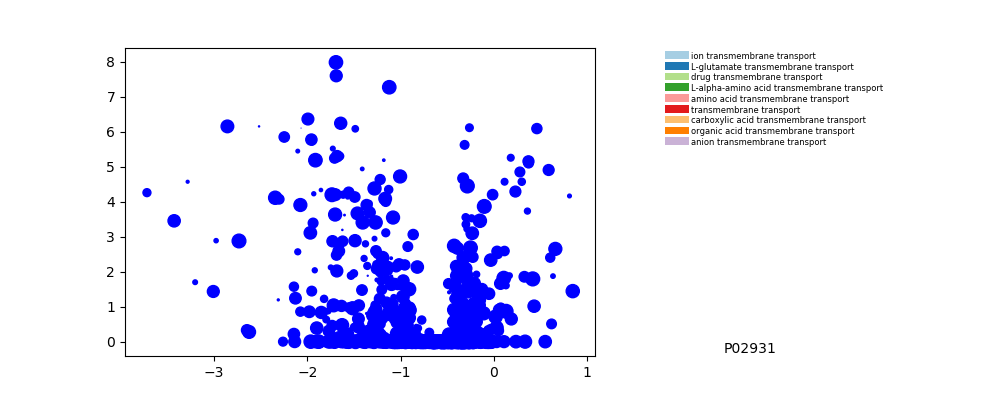

(0.0, 1.0, 0.0, 1.0)

In [121]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle



def colorByPathway(pathways, labels, cmap):
    colors = [ 'tab:gray' for n in labels ]
    
    for iPath, pathway in enumerate(reversed(pathways)):
        for protein in pathway['proteineTotal']:
                iProt = labels.index(protein)              
                colors[iProt] = cmap.colors[iPath]
                
    return colors

def createLegend(ax, pathways, cmap):
    
    rectHeight = 0.025
    rectWidth = 0.1
    legendSpacing = 0.01
    x = ax.get_xlim()
    y = ax.get_ylim()
    _x = x[0]
    _y = y[1]

    legendBoxes = []
    for i, p in enumerate(pathways[:cmap.N]):
        _y -= rectHeight + legendSpacing
        rect = Rectangle((_x, _y), rectWidth, rectHeight)
        legendBoxes.append(rect)
        ax.text(_x + rectWidth + 0.01, _y, p['name'], fontsize=6)
    pc = PatchCollection(legendBoxes, facecolor=cmap.colors)
    ax.add_collection(pc)

    ax.margins
    return legendBoxes

x,y, labels = (abundance, pvalue, allList)

cmap = plt.get_cmap('Paired')
color_node = colorByPathway(pathways[:cmap.N], labels, cmap)
def proteinListText(pathway):
    return  '\n'.join(pathway["proteineTotal"])

def getPathway(data, pathwayName = None, proteinName=None):
    res = []
    for d in data:
        if pathwayName : 
            if d['name'] == pathwayName:
                return [d]
        if proteinName : 
            if proteinName in d['proteineTotal']:
                res.append(d)
    if not res:
        raise ValueError("No pathway found")
    return res

def onpickUpdate(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    col.set_color(['b' for x in allList])
    col.set_sizes( np.random.rand(len(allList)) * 100 )
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4),gridspec_kw={'width_ratios': [3, 1.5]})
col = ax1.scatter(x, y, c=color_node, picker=True)

text = ax2.text(0.25, 0., "", va="bottom", ha="left")
cid = fig.canvas.mpl_connect('pick_event', onpickUpdate)

createLegendBoxes = createLegend(ax2, pathways, cmap ) 
ax2.axis('off')